#### Experiments to be sorted later

COMBINATION ID VERY EARLY - INSERT IT FOR LATER EVALUATION

What I need to do:

-Parameter tuning of RF



Data cleaning:
-average double entries
-use maccskeys for a RF

New dataset:
-fix variability above 100 down to 100
-

In [1]:
# temporary working here to deal with double values and insert it later as new section before section joining

In [1]:
import numpy as np
import pandas as pd
import _pickle as pkl

#### 2. Joining

In [2]:
with open('./intermediate-pickles-scoring2/dataWithSource.pkl', 'rb') as inp:
    data1 = pkl.load(inp)
with open('./intermediate-pickles-scoring2/data2.pkl', 'rb') as inp:
    data2 = pkl.load(inp)

In [3]:
data2 = data2[data2["HSA"]<84.4]

In [4]:
# double Data
dataReversed1 = data1
dataReversed2 = data2

dataReversed1 = dataReversed1.rename(columns={"Drug1":"Drug2","Drug2":"Drug1"})
dataReversed2 = dataReversed2.rename(columns={"Drug1":"Drug2","Drug2":"Drug1"})

dataDouble1 = data1.append(dataReversed1)
dataDouble2 = data2.append(dataReversed2)

dataDouble1.reset_index(inplace=True,drop=True)
dataDouble2.reset_index(inplace=True,drop=True)

print(len(dataDouble1)," records in first frame")
print(len(dataDouble2)," records in second frame")
dataDouble1.head(2)

492814  records in first frame
811376  records in second frame


,drug_drug2,ID,Drug1,Drug2,Cell line,ZIP,Bliss,Loewe,index,HSA,source
0,5-fuabt-888A2058,1,5-fu,abt-888,A2058,2.80125,9.4975,0.490625,284469,8.7775,ONEIL
1,5-fuazd1775A2058,5,5-fu,azd1775,A2058,9.81750,11.2075,5.837500,29611,14.0975,ONEIL


Drug Feature import part

In [5]:
from rdkit import Chem
from rdkit.Chem import MACCSkeys

drug_feats = pd.read_csv("./output/all_drugs_with_smiles.csv")
drug_feats["mol-object"]=[Chem.MolFromSmiles(mol) for mol in drug_feats["smilesString"]]

maccsFrame = pd.DataFrame(drug_feats["drugName"])
maccsFrame["MACCSk"] = [np.array(Chem.MACCSkeys.GenMACCSKeys(mol)) for mol in drug_feats["mol-object"]]

joinMaccs = pd.DataFrame([])
for i in range(len(maccsFrame)):
    joinMaccs = joinMaccs.append(pd.Series(maccsFrame.iloc[i,1]),ignore_index=True)
    
drugMACCS = maccsFrame.join(joinMaccs,how="left").drop(columns="MACCSk")

In [6]:
drugMACCS.head(2)

,drugName,0,1,2,3,4,5,6,7,8,...,157,158,159,160,161,162,163,164,165,166
0,Bendamustine,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
1,Lonidamine,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0


In [7]:
drug_feats = drugMACCS
drug_feats.set_index("drugName",inplace=True)
drug_feats.index = drug_feats.index.str.lower()

d1_drugs = drug_feats.add_prefix("D1 ")
d2_drugs = drug_feats.add_prefix("D2 ")

dataDouble_drug1_feats1 = dataDouble1.join(d1_drugs,on="Drug1",how="left")
dataDouble_drug1_feats2 = dataDouble2.join(d1_drugs,on="Drug1",how="left")

dataDouble_all_feats1 = dataDouble_drug1_feats1.join(d2_drugs,on="Drug2",how="left")
dataDouble_all_feats2 = dataDouble_drug1_feats2.join(d2_drugs,on="Drug2",how="left")

Cell Line Info from Ammar

In [8]:
# Ammars output files
cellLine_info = pd.read_csv('output/cell_lines_enriched.csv', sep=',', dtype='string')
drug_info = pd.read_csv('output/all_drugs_with_smiles.csv', sep=',', dtype='string')

cat_ohe = pd.get_dummies(cellLine_info.category, prefix='cat')
cellLine_info_full = pd.concat([cellLine_info,cat_ohe], axis=1)

gender_ohe = pd.get_dummies(cellLine_info.gender, prefix='gender')

cellLine_info_full['age'] = cellLine_info_full['age'].str.replace('Y','').replace('Age unspecified','0')
cellLine_info_full['age'] = cellLine_info_full['age'].astype('int')

cellLine_info_full = cellLine_info_full.drop('cosmicId', 1)
cellLine_info_full = cellLine_info_full.drop('category', 1)
cellLine_info_full = cellLine_info_full.drop('gender', 1)

In [12]:
data1 = dataDouble_all_feats1.join(cellLine_info_full.set_index("cellName"),on="Cell line", how="left").dropna() #expensive losses
data2 = dataDouble_all_feats2.join(cellLine_info_full.set_index("cellName"),on="Cell line", how="left").dropna()

In [29]:
# I don't think I need all these pickles stored
# with open('./intermediate-pickles-scoring2/finalFrame1.pkl', 'wb') as outp:
#     pkl.dump(finalFrame1, outp)
# with open('./intermediate-pickles-scoring2/finalFrame2.pkl', 'wb') as outp:
#     pkl.dump(finalFrame2, outp)

#### 3. Combination ID?

In [16]:
data1.reset_index(inplace=True,drop=True)
data2.reset_index(inplace=True,drop=True)
print("Data1 has records ",len(data1))
print("Data2 has records ",len(data2))
data1.head(2)

Data1 has records  468730
Data2 has records  614608


,drug_drug2,ID,Drug1,Drug2,Cell line,ZIP,Bliss,Loewe,index,HSA,...,D2 162,D2 163,D2 164,D2 165,D2 166,age,cat_Cancer cell line,cat_Embryonic stem cell,cat_Hybridoma,cat_Transformed cell line
0,5-fuabt-888A2058,1,5-fu,abt-888,A2058,2.80125,9.4975,0.490625,284469,8.7775,...,1.0,1.0,1.0,1.0,0.0,43.0,1.0,0.0,0.0,0.0
1,5-fuazd1775A2058,5,5-fu,azd1775,A2058,9.81750,11.2075,5.837500,29611,14.0975,...,1.0,1.0,1.0,1.0,0.0,43.0,1.0,0.0,0.0,0.0


#### 4. Making Predictions

In [26]:
Y1 = data1.iloc[:,9]
X1 = data1.iloc[:,11:]

Y2 = data2.iloc[:,9]
X2 = data2.iloc[:,10:]

from sklearn.model_selection import train_test_split
X_train1,x_test1,Y_train1,y_test1 = train_test_split(X1,Y1,test_size=0.3,stratify=Y1) #consider stratifying on combination
X_train2,x_test2,Y_train2,y_test2 = train_test_split(X2,Y2,test_size=0.3,stratify=Y2)

In [27]:
from sklearn.ensemble import RandomForestRegressor 

regressor1 = RandomForestRegressor(max_depth=4, random_state=0, n_estimators=100, verbose=True)
regressor1.fit(X_train1,Y_train1)

predTrain1=regressor1.predict(X_train1)
predTest1=regressor1.predict(x_test1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  6.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.6s finished


In [28]:
regressor2 = RandomForestRegressor(max_depth=4, random_state=0, n_estimators=100, verbose=True)
regressor2.fit(X_train2,Y_train2)

predTrain2=regressor2.predict(X_train2)
predTest2=regressor2.predict(x_test2)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  9.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.8s finished


In [32]:
YB = data1.iloc[:,9]
XB = data1.iloc[:,10:]

sourceDummies = pd.get_dummies(XB.source,prefix="Source")
XB[["Source_ALMANAC","Souce_ONEIL"]]=sourceDummies

XB.drop(["source"],axis=1,inplace=True)

XB.head(2)

,D1 0,D1 1,D1 2,D1 3,D1 4,D1 5,D1 6,D1 7,D1 8,D1 9,...,D2 164,D2 165,D2 166,age,cat_Cancer cell line,cat_Embryonic stem cell,cat_Hybridoma,cat_Transformed cell line,Source_ALMANAC,Souce_ONEIL
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,43.0,1.0,0.0,0.0,0.0,0,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,43.0,1.0,0.0,0.0,0.0,0,1


In [38]:
X_trainB,x_testB,Y_trainB,y_testB = train_test_split(XB,YB,test_size=0.3,stratify=YB) #consider stratifying on combination

regressorB = RandomForestRegressor(max_depth=4, random_state=0, n_estimators=100, verbose=True)
regressorB.fit(X_trainB,Y_trainB)

predTrainB=regressorB.predict(X_trainB)
predTestB=regressorB.predict(x_testB)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  6.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.6s finished


In [39]:
from sklearn.dummy import DummyRegressor

# Data1
dummyRegressor1 = DummyRegressor()
dummyRegressor1.fit(X_train1,Y_train1)

predTrainDumm1=dummyRegressor1.predict(X_train1)
predTestDumm1=dummyRegressor1.predict(x_test1)

#Data2
dummyRegressor2 = DummyRegressor()
dummyRegressor2.fit(X_train2,Y_train2)

predTrainDumm2=dummyRegressor2.predict(X_train2)
predTestDumm2=dummyRegressor2.predict(x_test2)

#Data B
dummyRegressorB = DummyRegressor()
dummyRegressorB.fit(X_trainB,Y_trainB)

predTrainDummB=dummyRegressorB.predict(X_trainB)
predTestDummB=dummyRegressorB.predict(x_testB)

#### Scoring (Mean Absolute/Squared Error)

In [34]:
print("## The performances are:")
print("\nSmall Dataset:")
print("On Training Data: ",np.mean(np.abs(predTrain1-Y_train1)))
print("On Testing  Data: ",np.mean(np.abs(predTest1-y_test1)))
print("Dummy Training  : ",np.mean(np.abs(predTrainDumm1-Y_train1)))
print("Dummy Testing   : ",np.mean(np.abs(predTestDumm1-y_test1)))
print("\nBig Dataset:")
print("On Training Data: ",np.mean(np.abs(predTrain2-Y_train2)))
print("On Testing  Data: ",np.mean(np.abs(predTest2-y_test2)))
print("Dummy Training  : ",np.mean(np.abs(predTrainDumm2-Y_train2)))
print("Dummy Testing   : ",np.mean(np.abs(predTestDumm2-y_test2)))

## The performances are:

Small Dataset:
On Training Data:  3.8735736195579915
On Testing  Data:  3.8925051812921905
Dummy Training  :  3.9970085632976433
Dummy Testing   :  4.020192456616437

Big Dataset:
On Training Data:  4.0489834412588905
On Testing  Data:  4.0597795306040805
Dummy Training  :  4.159212070389421
Dummy Testing   :  4.1722321269988685


In [35]:
print("## The performances are:")
print("\nSmall Dataset:")
print("On Training Data: ",np.mean(np.square(predTrain1-Y_train1)))
print("On Testing  Data: ",np.mean(np.square(predTest1-y_test1)))
print("Dummy Training  : ",np.mean(np.square(predTrainDumm1-Y_train1)))
print("Dummy Testing   : ",np.mean(np.square(predTestDumm1-y_test1)))
print("\nBig Dataset:")
print("On Training Data: ",np.mean(np.square(predTrain2-Y_train2)))
print("On Testing  Data: ",np.mean(np.square(predTest2-y_test2)))
print("Dummy Training  : ",np.mean(np.square(predTrainDumm2-Y_train2)))
print("Dummy Testing   : ",np.mean(np.square(predTestDumm2-y_test2)))

## The performances are:

Small Dataset:
On Training Data:  33.07288422243679
On Testing  Data:  34.16080958570555
Dummy Training  :  35.52366874305311
Dummy Testing   :  36.69735845712762

Big Dataset:
On Training Data:  35.524583660779705
On Testing  Data:  36.04437226826528
Dummy Training  :  37.92288193531876
Dummy Testing   :  38.46852403117986


In [40]:
#for source feature on small Dataset
print("## The performances for Big Tree are:")
print("\nMAE:")
print("On Training Data: ",np.mean(np.abs(predTrainB-Y_trainB)))
print("On Testing  Data: ",np.mean(np.abs(predTestB-y_testB)))
print("Dummy Training  : ",np.mean(np.abs(predTrainDummB-Y_trainB)))
print("Dummy Testing   : ",np.mean(np.abs(predTestDummB-y_testB)))
print("\nMSE:")
print("On Training Data: ",np.mean(np.square(predTrainB-Y_trainB)))
print("On Testing  Data: ",np.mean(np.square(predTestB-y_testB)))
print("Dummy Training  : ",np.mean(np.square(predTrainDummB-Y_trainB)))
print("Dummy Testing   : ",np.mean(np.square(predTestDummB-y_testB)))

## The performances for Big Tree are:

MAE:
On Training Data:  3.770320208092335
On Testing  Data:  3.79095900809306
Dummy Training  :  3.999038972029706
Dummy Testing   :  4.01597279816774

MSE:
On Training Data:  31.782656239156356
On Testing  Data:  32.73795414235455
Dummy Training  :  35.59075884711726
Dummy Testing   :  36.54072557781606


In [44]:
featsB = pd.DataFrame([np.array(x_testB.columns),regressorB.feature_importances_]).transpose()
featImportance = featsB.sort_values(by=1,ascending=False).head(20).reset_index(drop=True)
featImportance.rename(columns={0:"Feat B",1:"Relevance B"},inplace=True)

feats1 = pd.DataFrame([np.array(x_test1.columns),regressor1.feature_importances_]).transpose()
featImportance[["Feat 1","Relevance 1"]] = feats1.sort_values(by=1,ascending=False).head(20).reset_index(drop=True)

feats2 = pd.DataFrame([np.array(x_test2.columns),regressor2.feature_importances_]).transpose()
featImportance[["Feat 2","Relevance 2"]] = feats2.sort_values(by=1,ascending=False).head(20).reset_index(drop=True)
featImportance

#  145: ('*1~*~*~*~*~*~1', 1),  # 6M ring > 1
# absolutely no idea why this is so disproportionately important
# Even After source: It's not a proxy (actually evenly distributed)
# probably all other are completely irrelavant and this is the only one with at least something

,Feat B,Relevance B,Feat 1,Relevance 1,Feat 2,Relevance 2
0,Souce_ONEIL,0.415335,D2 145,0.279642,D2 145,0.31196
1,Source_ALMANAC,0.177741,D1 145,0.265141,D1 145,0.296716
2,D2 145,0.111691,D1 150,0.075136,D1 97,0.041471
3,D1 145,0.088233,D2 150,0.071736,D1 154,0.041178
4,D1 79,0.031438,D2 138,0.067723,D2 97,0.039991
5,D1 144,0.02882,D2 50,0.026705,D2 154,0.038564
6,D2 144,0.024271,D1 77,0.019802,D2 150,0.029796
7,D2 79,0.02111,D1 50,0.019659,D1 150,0.028593
8,D2 89,0.019749,D1 153,0.015196,D1 141,0.027942
9,D1 89,0.010247,D1 138,0.015154,D2 141,0.023138


#### Parameter Tuning

First I'll try different sizes of max_samples, max_depth, min_samples_split on a 2-Tree forest

In [ ]:
scoresTrain = []
scoresTest = []

length = 328111
max_samplesF = [0.001,0.01,0.1,0.2,0.5,1.0]
max_depthF = [24,16,12,8,4,2]
min_samples_splitF = [2,3,5,10,20,100]

print("done")
for k in max_samplesF:
    localTrain2= []
    localTest2 = []
    for j in max_depthF:
        localTrain1= []
        localTest1 = []
        for i in min_samples_splitF:
            regressorN = RandomForestRegressor(max_depth=j, max_samples=k,
                                               min_samples_split = i, bootstrap=True, n_jobs=-1,
                                               n_estimators=2, verbose=True)
            regressorN.fit(X_trainB,Y_trainB)
        
            localTrain1.append(np.mean(np.abs(regressorN.predict(x_testB)-y_testB))) #do also train
            localTest1.append(np.mean(np.abs(regressorN.predict(X_trainB)-Y_trainB))) 
        localTrain2.append(localTrain1)
        localTest2.append(localTest1)
        del regressorN
    scoresTrain.append(localTrain2)
    scoresTest.append(localTest2)

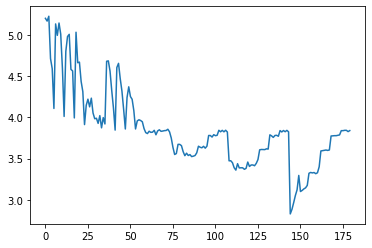

In [152]:
scoresVis = np.array(scoresTest)
from matplotlib import pyplot as plt
plt.plot(scoresVis.flatten())

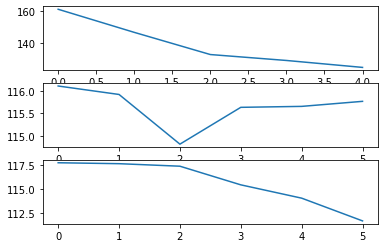

In [170]:
arrMaxSamples = [0,0,0,0,0]
arrMinSampleSplit = [0,0,0,0,0,0]
arrMaxDepth = [0,0,0,0,0,0]
for i in range(5):
    for j in range(6):
        for k in range(6):
            arrMaxSamples[i]+=scoresVis[i][j][k]
            arrMaxDepth[j]+=scoresVis[i][j][k]
            arrMinSampleSplit[k]+=scoresVis[i][j][k]

fig,ax=plt.subplots(3)
ax[0].plot(arrMaxSamples)
ax[1].plot(arrMaxDepth)
ax[2].plot(arrMinSampleSplit)

Note that
-overall shrinking: implying biggest impact from a bigger number in max_samples
-5 partitions each rising: implying more depth is better
-shrinking plateaus of 5 datapoints being straight: min samples split bigger

In [175]:
scoresTrain = []
scoresTest = []

max_samplesF = [0.001,0.01,0.3,0.9999]
max_depthF = [24,10,4,2]
min_samples_splitF = [2,7,30,100]
no_trees = [5,100,600]

print("starting now")
for k in max_samplesF:
    localTrain3= []
    localTest3 = []
    for j in max_depthF:
        localTrain2= []
        localTest2 = []
        for i in min_samples_splitF:
            localTrain1= []
            localTest1 = []
            for l in no_trees:
                regressorN = RandomForestRegressor(max_depth=j, max_samples=k,
                                               min_samples_split = i, bootstrap=True, n_jobs=-1,
                                               n_estimators=l, verbose=True)
                regressorN.fit(X_trainB,Y_trainB)
        
                localTrain1.append(np.mean(np.abs(regressorN.predict(x_testB)-y_testB))) #do also train
                localTest1.append(np.mean(np.abs(regressorN.predict(X_trainB)-Y_trainB))) 
                del regressorN
            localTrain2.append(localTrain1)
            localTest2.append(localTest1)
        localTrain3.append(localTrain2)
        localTest3.append(localTest2)
        
    scoresTrain.append(localTrain3)
    scoresTest.append(localTest3)

done


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 128 concurrent workers.


AttributeError: 'DummyProcess' object has no attribute 'terminate'

Next steps:

Cell Line Profiles